In [2]:
import layoutparser as lp
from PIL import Image
import numpy as np

In [88]:
model = lp.Detectron2LayoutModel(
            config_path ='lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', # In model catalog
            label_map   ={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [89]:
model = lp.Detectron2LayoutModel(
            config_path = './CUSTOM_models/binary_model/config.yaml',
            model_path  = './CUSTOM_models/binary_model/model_final.pth',
            label_map   = {1:"Paragraph", 2:"Other"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )

In [90]:
im = Image.open('./test_set/00001272.tif')

layout = model.detect(im)

/home/georgi006/.local/lib/python3.8/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


### Union
All intersections above a cetrain <u>threshold</u> are merged.

In [91]:
def intersection_over_union(a,b):
    x1 = max(a.block.x_1, b.block.x_1)
    y1 = max(a.block.y_1, b.block.y_1)
    x2 = min(a.block.x_2, b.block.x_2)
    y2 = min(a.block.y_2, b.block.y_2)
    if (y2-y1) <= 0 or (x2-x1) <= 0:
        return 0

    intersection = (x2-x1)*(y2-y1)

    areaA = (a.block.x_2 - a.block.x_1) * (a.block.y_2 - a.block.y_1)
    areaB = (b.block.x_2 - b.block.x_1) * (b.block.y_2 - b.block.y_1)

    iou = intersection / (areaA + areaB - intersection)

    return iou

def unions(blocks, threshold=250):
    unions = []
    disappear = []
    count = 1
    while count != 0:
        count = 0
        for i in range(len(blocks)):
            if i in disappear:
                continue
            not_intersect = True
            for j in range(i+1, len(blocks)):
                if intersection_over_union(blocks[i], blocks[j]) > 0 and abs(blocks[i].block.x_1-blocks[j].block.x_1) < threshold:
                    unions.append(blocks[i].union(blocks[j]))
                    disappear.append(j)
                    not_intersect = False
                    count += 1
            if not_intersect:
                unions.append(blocks[i])
        blocks = unions
        unions = []
        disappear = []

    return lp.Layout(blocks)

### Sort
Sort the reading order from left to right and from top to bottom.

In [92]:
def sorting(text_blocks, image, threshold=500):
    arr_im = np.asarray(im)

    height, width = arr_im.shape[:2]

    text_blocks.sort(key = lambda b:b.coordinates[0], inplace=True)

    intervals = []

    for i in range(len(text_blocks)):
        x_1 = text_blocks[i].block.x_1
        if i == 0:
            intervals.append(x_1)
            curr_x = x_1
        else:
            if (x_1 - curr_x) >= threshold:
                intervals.append(x_1)
                curr_x = x_1  

    blocks = []

    for i in range(len(intervals)):
        if i == len(intervals) - 1:
            curr_interval = lp.Interval(intervals[i],width, axis='x').put_on_canvas(im)
        else:
            curr_interval = lp.Interval(intervals[i], intervals[i+1], axis='x').put_on_canvas(im)
        block = text_blocks.filter_by(curr_interval, center=True)
        block.sort(key = lambda b:b.coordinates[1], inplace=True)
        blocks.append(block)

    bl = blocks[0]
    for i in range(1,len(blocks)):
        bl += blocks[i]

    return lp.Layout([b.set(id = idx) for idx, b in enumerate(bl)])

In [93]:
def left_to_right_overlap(text_blocks):
    for i in range(len(text_blocks)):
        for j in range(i+1, len(text_blocks)):
            if intersection_over_union(text_blocks[i], text_blocks[j]) > 0:
                right_rec_percentage = (text_blocks[i].block.x_2-text_blocks[j].block.x_1) / (text_blocks[i].block.x_2-text_blocks[i].block.x_1)
                left_rec_percentage  = (text_blocks[i].block.x_2-text_blocks[j].block.x_1) / (text_blocks[j].block.x_2-text_blocks[j].block.x_1)
                if right_rec_percentage >= left_rec_percentage:
                    text_blocks[j].block.x_1 = text_blocks[i].block.x_2
                else:
                    text_blocks[i].block.x_2 = text_blocks[j].block.x_1
    
    return text_blocks


In [94]:
text_blocks = lp.Layout([b for b in layout if b.type=='Paragraph'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Other'])

text_blocks = lp.Layout([b for b in text_blocks if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

text_blocks = lp.Layout([i.pad(left=15, right=15, top=15, bottom=15) for i in text_blocks])

text_blocks = unions(text_blocks)

text_blocks = sorting(text_blocks, im)

text_blocks = left_to_right_overlap(text_blocks)

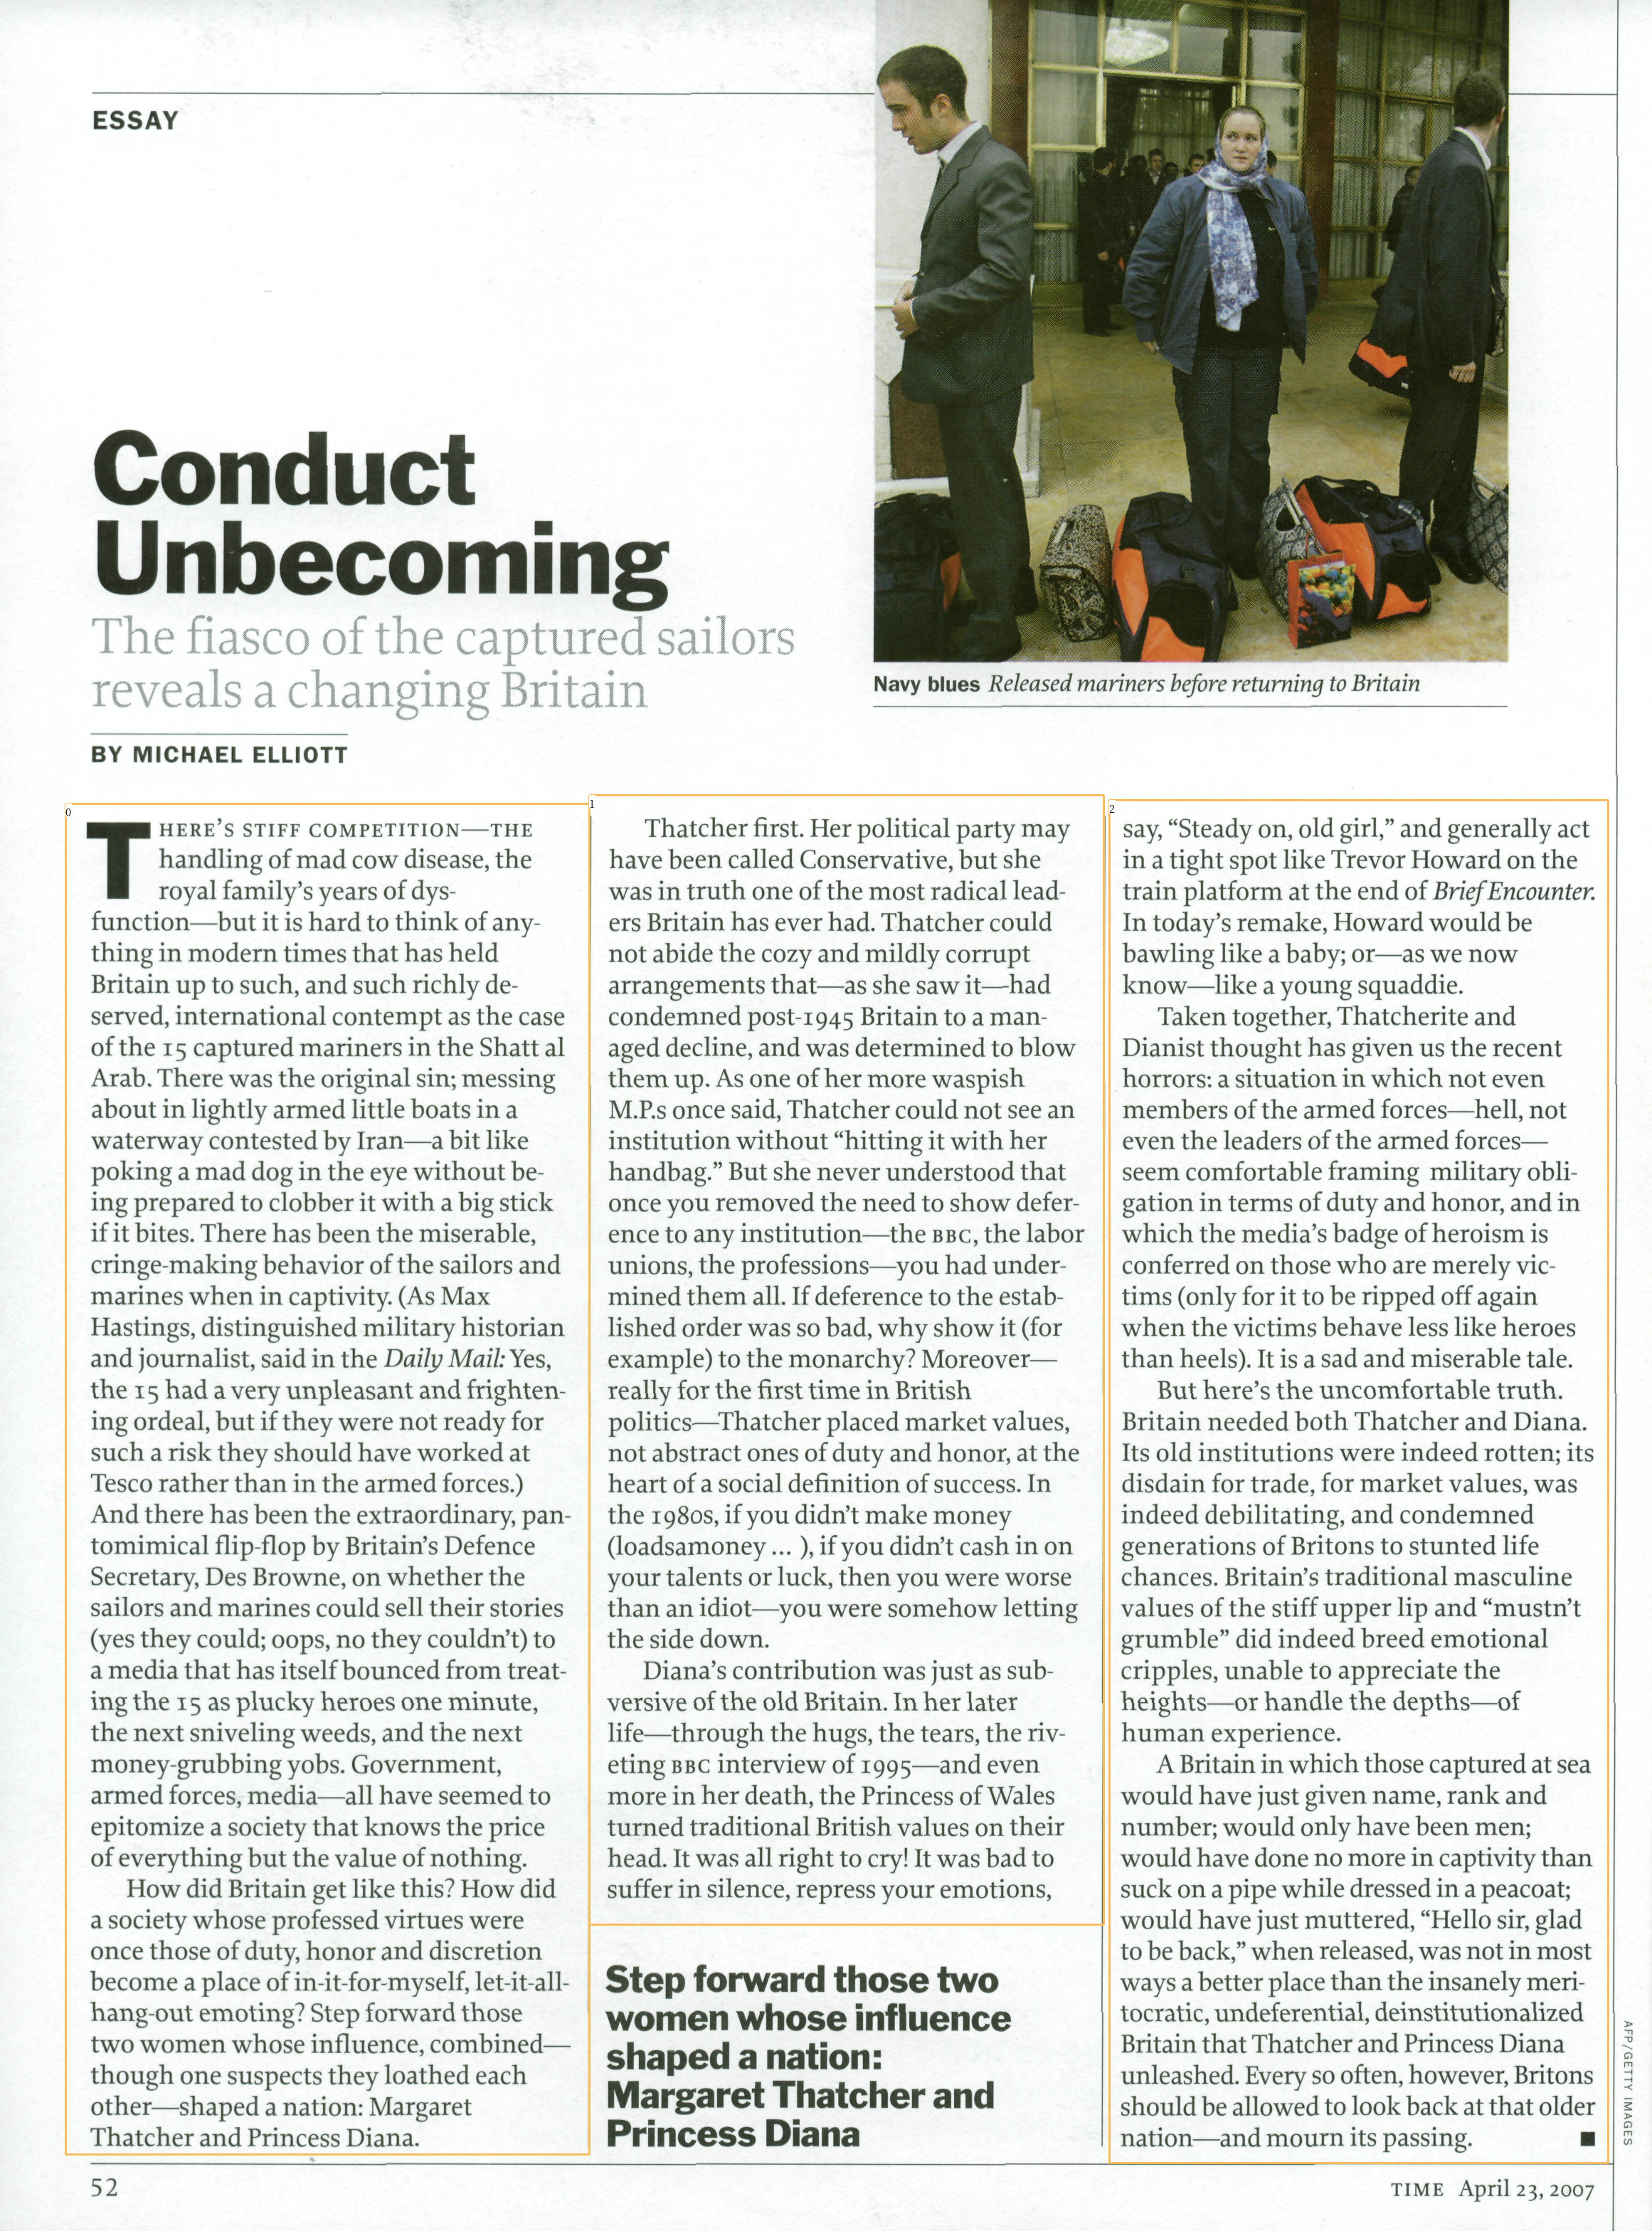

In [95]:
lp.draw_box(im, text_blocks,
            box_width=3, 
            show_element_id=True)

In [45]:
ocr_agent = lp.TesseractAgent(languages='eng') 

In [83]:
arr_im = np.asarray(im)

for block in unions(text_blocks):
    segment_image = (block.crop_image(arr_im))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)


for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

is a tiny travel agency in London
whose 150 clients include business lead-
ers, music and film honchos and other
names you know. Its phone number is
unlisted, and its website is a dead end,
displaying only a dramatic image of the
planet’s surface and an enigmatic mes-
sage: “Membership is currently restrict-
ed to recommendations from existing
clients or by invitation.” There are no
further links. No one has been invited
in five years, maybe more.
“We're really not mysterious, but we
are rare,” says founder Glen Donovan,
42, who after rigorous screening does, in fact, come to the phone—and
not without a giggle over the secrecy of it all.

The rarest thing about Earth is that it purveys stratospheric levels
of luxury. So élite is the travel that even the poshest hot spots are deep-
sixed. “I would say we reject, in the nicest way possible, about 80% of
what other companies promote as luxurious,” Donovan says. On the
docket instead are undiscovered, off-the-radar corners of the globe, mo